# IMECA's Cuauh

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter("ignore")

plt.style.use('bmh')

In [2]:
#help(Prophet)

In [3]:
def mape(y_true, y_pred):
    y_true, y_pred=np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

def smape(y_true,y_pred):
    return ((y_true - y_pred).abs() / (y_true.abs() + y_pred.abs())).mean() * 200

In [4]:
def imeca_calculation(a):
    imeca = []
    for e in a:
        e=round(e)
        if (e>0)&(e<=40):
            k= (50-0)/(40-0)
            im=k*(e-0) + 0
            imeca.append(round(im))

        elif (e>=41) & (e<=75):
            k=(100-51)/(75-41)
            im=k*(e-41) + 51
            imeca.append(round(im))

        elif (e>=76) & (e<=214):
            k=(150-101)/(214-76)
            im=k*(e-76) + 101
            imeca.append(round(im))

        elif (e>=215) & (e<=354):
            k=(200-151)/(354-215)
            im=k*(e-215) + 151
            imeca.append(round(im))

        elif (e>=355) & (e<=424):
            k=(300-201)/(424-355)
            im=k*(e-355) + 201
            imeca.append(round(im))

    return imeca

In [5]:
def categorizando(df):
    lst=[]
    for e in df:
        if (e>=0) & (e<50):
            lst.append('Buena')
        elif (e>=50) & (e<100):
            lst.append('Regular')
        elif (e>=100) & (e<150):
            lst.append('Mala')
        elif (e>=150) & (e<200):
            lst.append('Muy mala')
        else:
            lst.append('Ya vete de aquí woe')
    return lst

In [6]:
def comparando_categorias(a,b):
    lst=[]
    for e in range(len(a)):
        if a[e] == b[e]:
            lst.append(1)
        else:
            lst.append(0)
    return lst

### Leyendo CSV de IMECA's directos

In [7]:
cuauh_imeca_real = pd.read_excel("../data_aircdmx/imeca2019.xls")

In [8]:
cuauh_imeca_real.Fecha.head()

0   2019-01-01
1   2019-01-01
2   2019-01-01
3   2019-01-01
4   2019-01-01
Name: Fecha, dtype: datetime64[ns]

In [9]:
cuauh_imeca_real.tail()

,Fecha,Hora,Noroeste ozono,Noroeste dióxido de azufre,Noroeste dióxido de nitrógeno,Noroeste monóxido de carbono,Noroeste PM10,Noroeste PM25,Noreste ozono,Noreste dióxido de azufre,...,Suroeste dióxido de nitrógeno,Suroeste monóxido de carbono,Suroeste PM10,Suroeste PM25,Sureste ozono,Sureste dióxido de azufre,Sureste dióxido de nitrógeno,Sureste monóxido de carbono,Sureste PM10,Sureste PM25
7291,2019-10-31,20,9,4,10,2,40,62,9,4,...,10,3,26,56,2,4,12,3,38,68
7292,2019-10-31,21,7,4,12,2,39,59,9,2,...,9,3,25,55,2,4,12,3,36,66
7293,2019-10-31,22,7,4,11,2,38,58,6,2,...,9,3,24,55,1,4,12,3,35,64
7294,2019-10-31,23,9,4,11,2,38,57,4,2,...,10,2,24,54,1,4,12,4,35,62
7295,2019-10-31,24,8,4,11,2,36,56,4,2,...,9,2,24,53,2,4,11,4,36,61


In [10]:
cuauh_imeca_real.Hora[cuauh_imeca_real.Hora==24] = 00
cuauh_imeca_real.Fecha=cuauh_imeca_real.Fecha.apply(str)
cuauh_imeca_real.Fecha=cuauh_imeca_real.Fecha.apply(lambda x: x.replace(' 00:00:00',''))
cuauh_imeca_real['DATETIME']=cuauh_imeca_real.Fecha + ' ' + cuauh_imeca_real.Hora.apply(str)+':00:00'
#df.DATETIME=df.DATETIME.apply(lambda x: x.replace(' 00:00:00',''))
cuauh_imeca_real.DATETIME=pd.to_datetime(cuauh_imeca_real.DATETIME)

In [11]:
cuauh_imeca_real.DATETIME.tail()

7291   2019-10-31 20:00:00
7292   2019-10-31 21:00:00
7293   2019-10-31 22:00:00
7294   2019-10-31 23:00:00
7295   2019-10-31 00:00:00
Name: DATETIME, dtype: datetime64[ns]

In [12]:
cuauh_imeca_real.columns

Index(['Fecha', 'Hora', 'Noroeste ozono', 'Noroeste dióxido de azufre',
       'Noroeste dióxido de nitrógeno', 'Noroeste monóxido de carbono',
       'Noroeste PM10', 'Noroeste PM25', 'Noreste ozono',
       'Noreste dióxido de azufre', 'Noreste dióxido de nitrógeno',
       'Noreste monóxido de carbono', 'Noreste PM10', 'Noreste PM25',
       'Centro ozono', 'Centro dióxido de azufre',
       'Centro dióxido de nitrógeno', 'Centro monóxido de carbono',
       'Centro PM10', 'Centro PM25', 'Suroeste ozono',
       'Suroeste dióxido de azufre', 'Suroeste dióxido de nitrógeno',
       'Suroeste monóxido de carbono', 'Suroeste PM10', 'Suroeste PM25',
       'Sureste ozono', 'Sureste dióxido de azufre',
       'Sureste dióxido de nitrógeno', 'Sureste monóxido de carbono',
       'Sureste PM10', 'Sureste PM25', 'DATETIME'],
      dtype='object')

In [13]:
cuauh_imeca_real=cuauh_imeca_real[['DATETIME','Centro PM10']]
cuauh_imeca_real=cuauh_imeca_real.set_index('DATETIME')

cuauh_imeca_mean=cuauh_imeca_real.groupby(pd.TimeGrouper('D')).mean()
cuauh_imeca_max=cuauh_imeca_real.groupby(pd.TimeGrouper('D')).max()

In [14]:
cuauh_imeca_mean.head()

,Centro PM10
DATETIME,
2019-01-01,103.666667
2019-01-02,107.125000
2019-01-03,99.666667
2019-01-04,95.875000
2019-01-05,98.666667


In [15]:
cuauh_imeca_max.head()

,Centro PM10
DATETIME,
2019-01-01,115
2019-01-02,114
2019-01-03,106
2019-01-04,101
2019-01-05,106


### Leyendo CSV de medición de PM10

In [16]:
cuauh_imeca = pd.read_csv("../data_aircdmx/imeca_pm_2019.csv")

In [17]:
cuauh_imeca['date']=pd.to_datetime(cuauh_imeca['\tdate'],format='%d/%m/%Y')

In [18]:
cuauh_imeca = cuauh_imeca[(cuauh_imeca.id_station == 'HGM') & (cuauh_imeca.id_parameter == 'PM10')]
cuauh_imeca.head(6)

,date,id_station,id_parameter,value,unit,date
10,01/01/2019,HGM,PM10,77,2,2019-01-01
48,02/01/2019,HGM,PM10,65,2,2019-01-02
85,03/01/2019,HGM,PM10,49,2,2019-01-03
125,04/01/2019,HGM,PM10,60,2,2019-01-04
163,05/01/2019,HGM,PM10,71,2,2019-01-05
201,06/01/2019,HGM,PM10,54,2,2019-01-06


In [19]:
cuauh_imeca.isnull().sum()

\tdate          0
id_station      0
id_parameter    0
value           0
unit            0
date            0
dtype: int64

In [20]:
cuauh_imeca=cuauh_imeca.set_index("date")
cuauh_imeca.head()

,date,id_station,id_parameter,value,unit
date,,,,,
2019-01-01,01/01/2019,HGM,PM10,77,2
2019-01-02,02/01/2019,HGM,PM10,65,2
2019-01-03,03/01/2019,HGM,PM10,49,2
2019-01-04,04/01/2019,HGM,PM10,60,2
2019-01-05,05/01/2019,HGM,PM10,71,2


## Ejecución del modelo

In [21]:
cuauh_clean = pd.read_csv("../data_clean/cuauh_pm10_clean_v2.csv",index_col=[1])
cuauh_clean.drop("Unnamed: 0",axis=1,inplace=True)

In [22]:
cuauh_modelo= cuauh_clean.drop(["FECHA","HORA"],axis=1)

split_date2='2019-01-01'
split_date1='2015-04-01'

train=cuauh_modelo[(cuauh_modelo.index>=split_date1)&(cuauh_modelo.index<split_date2)].copy()
test=cuauh_modelo[cuauh_modelo.index>split_date2].copy()

### Preparando para fbprophet

In [23]:
train=train.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})
test=test.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})

train.ds=pd.to_datetime(train.ds)
test.ds=pd.to_datetime(test.ds)

In [30]:
modelo=Prophet(n_changepoints=10,
               holidays=holidays_df,
               changepoints=['2016-01-01','2017-02-01','2018-01-01','2018-12-31'],
               changepoint_prior_scale=0.5,
               #yearly_seasonality=15,
               #weekly_seasonality=True,
               #daily_seasonality=False,
               #yearly_seasonality=True,
               #seasonality_prior_scale =25
               #seasonality_mode='multiplicative'
              ).fit(train)

In [31]:
pred=modelo.predict(test)

In [32]:
mape(test.y, pred.yhat), smape(test.y, pred.yhat)

(39.26946217461448, 38.863653285214355)

In [33]:
mean_squared_error(test.y, pred.yhat)**0.5

19.024204171594455

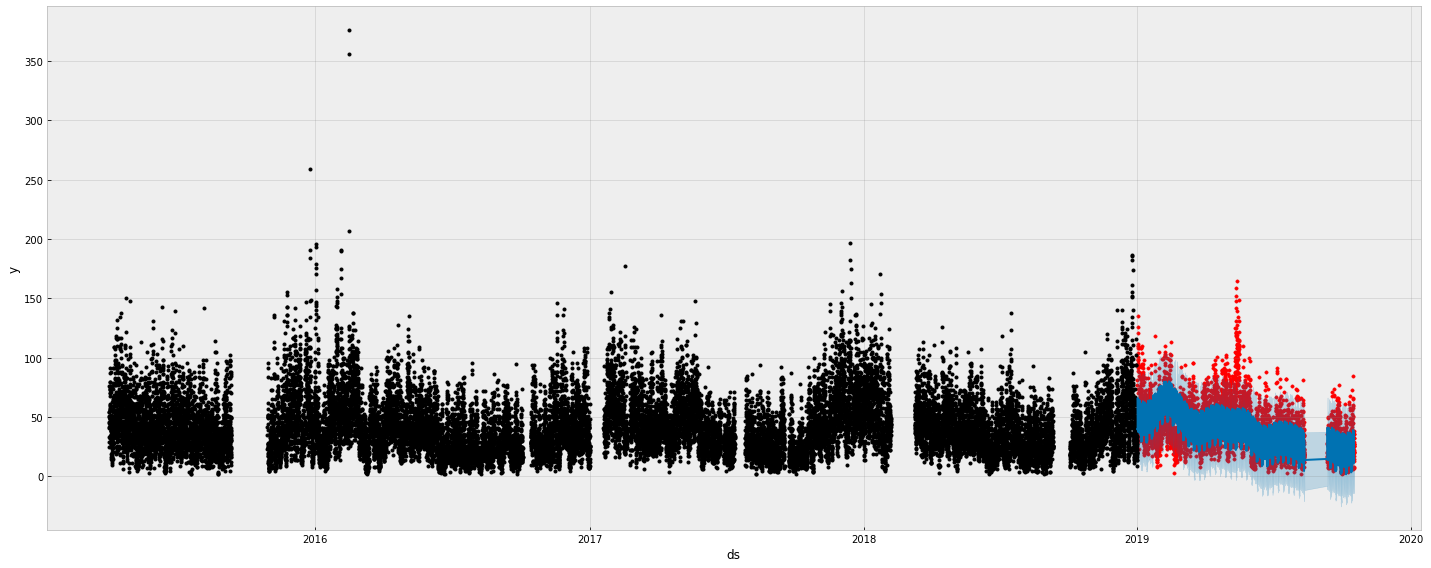

In [34]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(20)
ax.scatter(test.ds, test.y, color='r',s=11)
fig=modelo.plot(pred, ax)

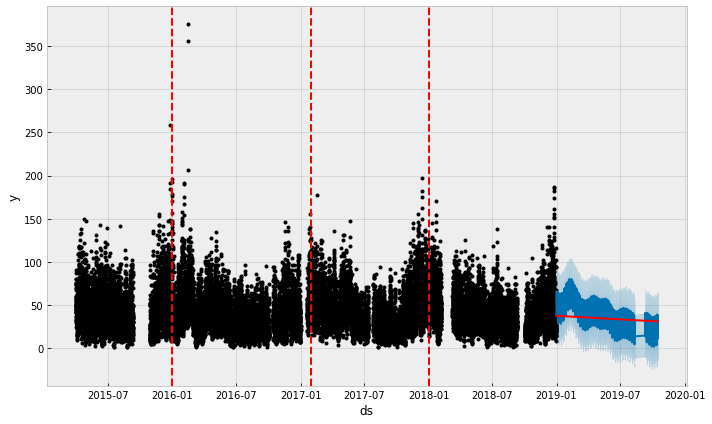

In [105]:
from fbprophet.plot import add_changepoints_to_plot
#ploteando change_pints del modelo
fig = modelo.plot(pred)
a = add_changepoints_to_plot(fig.gca(), modelo, pred)

# Conversión a IMECA y comparación

### Predicción

In [35]:
df_pred=pd.DataFrame(pred[['ds','yhat']])
df_pred=df_pred.set_index('ds')

In [36]:
df_pred_mean=df_pred.groupby(pd.TimeGrouper('D')).mean()
df_pred_max=df_pred.groupby(pd.TimeGrouper('D')).max()

In [37]:
df_pred_mean.shape

(289, 1)

In [38]:
df_pred_mean.isnull().sum() #13 NANs
df_pred_mean=df_pred_mean.dropna()
df_pred_max=df_pred_max.dropna()

In [39]:
df_pred_mean.shape

(255, 1)

In [40]:
df_pred_mean['imeca_pred']=imeca_calculation(df_pred_mean.yhat)
df_pred_max['imeca_pred']=imeca_calculation(df_pred_max.yhat)
df_pred_mean.head()

,yhat,imeca_pred
ds,,
2019-01-01,48.102683,61
2019-01-02,46.908656,60
2019-01-03,45.738810,58
2019-01-04,45.781183,58
2019-01-05,43.277330,54


### Cuauh's PM10

In [41]:
cuauh_imeca['imeca']=imeca_calculation(cuauh_imeca.value)
cuauh_imeca.head()

,date,id_station,id_parameter,value,unit,imeca
date,,,,,,
2019-01-01,01/01/2019,HGM,PM10,77,2,101
2019-01-02,02/01/2019,HGM,PM10,65,2,86
2019-01-03,03/01/2019,HGM,PM10,49,2,63
2019-01-04,04/01/2019,HGM,PM10,60,2,78
2019-01-05,05/01/2019,HGM,PM10,71,2,94


In [42]:
df_comparison=df_pred_mean.join(cuauh_imeca)[['yhat','imeca_pred','imeca']]
df_comparison2=df_pred_max.join(cuauh_imeca)[['yhat','imeca_pred','imeca']]
df_comparison=df_comparison.dropna()

In [43]:
df_comparison['categoria_pred']=categorizando(df_comparison.imeca_pred)
df_comparison['categoria_value']=categorizando(df_comparison.imeca)
df_comparison.head()
df_comparison2['categoria_pred']=categorizando(df_comparison2.imeca_pred)
df_comparison2['categoria_value']=categorizando(df_comparison2.imeca)

In [44]:
df_comparison['comparacion_imecas']=comparando_categorias(df_comparison.categoria_pred,df_comparison.categoria_value)
df_comparison2['comparacion_imecas']=comparando_categorias(df_comparison2.categoria_pred,df_comparison2.categoria_value)
df_comparison.tail(10)

,yhat,imeca_pred,imeca,categoria_pred,categoria_value,comparacion_imecas
ds,,,,,,
2019-10-07,15.950517,20,24.0,Buena,Buena,1
2019-10-08,19.333285,24,21.0,Buena,Buena,1
2019-10-09,18.702841,24,22.0,Buena,Buena,1
2019-10-10,17.541035,22,39.0,Buena,Buena,1
2019-10-11,18.957208,24,38.0,Buena,Buena,1
2019-10-12,17.273600,21,29.0,Buena,Buena,1
2019-10-13,12.427440,15,38.0,Buena,Buena,1
2019-10-14,17.836813,22,41.0,Buena,Buena,1
2019-10-15,21.145087,26,50.0,Buena,Regular,0


In [45]:
df_comparison.comparacion_imecas.value_counts()

1    169
0     83
Name: comparacion_imecas, dtype: int64

In [46]:
169/255

0.6627450980392157

Con el modelo actual, el % de aciertos de IMECA es 60%-80% tanto para el cálculo del IMECA con base al promedio, así como sacando el máximo valor de predicción.

# Comparación directa de IMECA

### Predicción

In [106]:
df_pred=pd.DataFrame(pred[['ds','yhat']])
df_pred=df_pred.set_index('ds')

In [107]:
df_pred_mean=df_pred.groupby(pd.TimeGrouper('D')).mean()
df_pred_max=df_pred.groupby(pd.TimeGrouper('D')).max()

In [108]:
df_pred_mean.shape

(289, 1)

In [109]:
df_pred_mean.isnull().sum() #13 NANs
df_pred_mean=df_pred_mean.dropna()
df_pred_max=df_pred_max.dropna()

In [110]:
df_pred_mean.shape

(255, 1)

In [111]:
df_pred_mean['imeca_pred']=imeca_calculation(df_pred_mean.yhat)
df_pred_max['imeca_pred']=imeca_calculation(df_pred_max.yhat)
df_pred_max.head()

,yhat,imeca_pred
ds,,
2019-01-01,66.082120,87
2019-01-02,64.456389,84
2019-01-03,64.522108,86
2019-01-04,63.416888,83
2019-01-05,61.674450,81


### Cuauh's IMECA real

In [90]:
cuauh_imeca_max.head()

,Centro PM10
DATETIME,
2019-01-01,115
2019-01-02,114
2019-01-03,106
2019-01-04,101
2019-01-05,106


In [114]:
df_comparison=df_pred_max.join(cuauh_imeca_max)[['yhat','imeca_pred','Centro PM10']]
df_comparison['categoria_pred']=categorizando(df_comparison.imeca_pred)
df_comparison['categoria_real']=categorizando(df_comparison['Centro PM10'])
df_comparison['comparacion_imecas']=comparando_categorias(df_comparison.categoria_pred,df_comparison.categoria_real)

In [115]:
df_comparison.comparacion_imecas.value_counts()

1    155
0    100
Name: comparacion_imecas, dtype: int64

In [117]:
155/255

0.6078431372549019

## Explorando holidays

In [25]:
import holidays

In [26]:
holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

In [27]:
ldates = []
lnames = []
for date, name in sorted(holidays.MX(years=np.arange(2015, 2019)).items()):
    ldates.append(date)
    lnames.append(name)

In [28]:
ldates = np.array(ldates)
lnames = np.array(lnames)

In [29]:
holidays_df.loc[:,'ds'] = ldates
holidays_df.loc[:,'holiday'] = lnames
holidays_df.holiday

0                            Año Nuevo [New Year's Day]
1             Día de la Constitución [Constitution Day]
2     Natalicio de Benito Juárez [Benito Juárez's bi...
3                          Día del Trabajo [Labour Day]
4            Día de la Independencia [Independence Day]
5                 Día de la Revolución [Revolution Day]
6                                   Navidad [Christmas]
7                            Año Nuevo [New Year's Day]
8             Día de la Constitución [Constitution Day]
9     Natalicio de Benito Juárez [Benito Juárez's bi...
10                         Día del Trabajo [Labour Day]
11    Natalicio de Benito Juárez [Benito Juárez's bi...
12           Día de la Independencia [Independence Day]
13                Día de la Revolución [Revolution Day]
14                                  Navidad [Christmas]
15    Transmisión del Poder Ejecutivo Federal [Chang...
16                           Año Nuevo [New Year's Day]
17                Año Nuevo [New Year's Day] (Ob